In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [36]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch

In [15]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['target'])
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [18]:
# Prepare dataset

class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, labeled=True):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.labeled = labeled

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text = self.dataframe.iloc[index]['text']
        inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')

        if self.labeled:
            label = self.dataframe.iloc[index]['target']
            return {
                'input_ids': inputs['input_ids'].flatten(),
                'attention_mask': inputs['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'input_ids': inputs['input_ids'].flatten(),
                'attention_mask': inputs['attention_mask'].flatten()
            }

train_dataset = TweetDataset(df_train, tokenizer)
val_dataset = TweetDataset(df_val, tokenizer)
test_dataset = TweetDataset(df_test, tokenizer, labeled=False)

In [27]:
# Set training parameters

training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    logging_steps=100,  # Log metrics every 100 steps
    save_total_limit=2,  # Only keep the two most recent checkpoints to save space
    evaluation_strategy='steps',  # Evaluate every evaluation_steps
    eval_steps=100,  # Evaluation and Save happens every 500 steps
    save_steps=100,  # Save the model every 500 steps
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Assuming you've already created a PyTorch Dataset
    eval_dataset=val_dataset,     # Assuming you've already created a PyTorch Dataset for validation
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
trainer.train()

Step,Training Loss,Validation Loss
100,0.574600,0.414661
200,0.438200,0.427036
300,0.427400,0.395559
400,0.410400,0.413692
500,0.334700,0.456598
600,0.348900,0.398795
700,0.357100,0.411934


TrainOutput(global_step=762, training_loss=0.409885654299278, metrics={'train_runtime': 860.4482, 'train_samples_per_second': 14.155, 'train_steps_per_second': 0.886, 'total_flos': 3204692654284800.0, 'train_loss': 0.409885654299278, 'epoch': 2.0})

In [29]:
predictions = trainer.predict(train_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

def displayConfusionMatrix(y_true, y_pred, dataset):
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Disaster', 'Disaster'])
    disp = disp.plot(include_values=True, cmap='Blues', ax=plt.gca())
    disp.ax_.set_title(f'Confusion Matrix on {dataset} Dataset -- F1 Score: {f1_score(y_true, y_pred):.2f}')

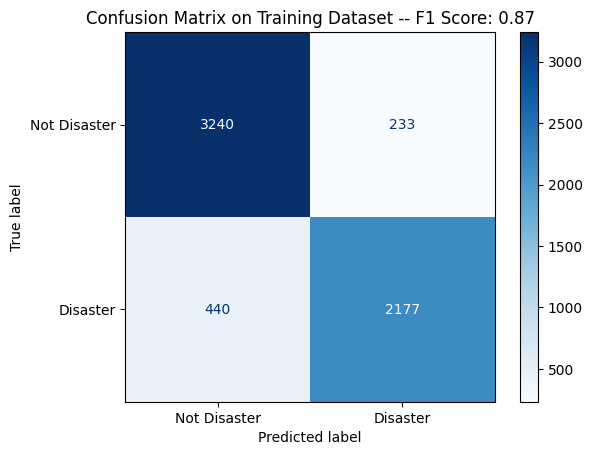

In [31]:
displayConfusionMatrix(true_labels, pred_labels, "Training")

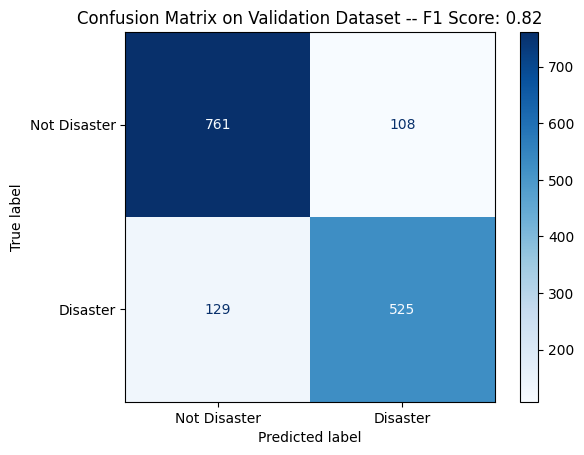

In [32]:
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

displayConfusionMatrix(true_labels, pred_labels, "Validation")

In [77]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [40]:
# Make predictions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_loader = DataLoader(test_dataset, batch_size=32)
predictions = []
for batch in test_loader:
    inputs = {
        'input_ids': batch['input_ids'].to(device),
        'attention_mask': batch['attention_mask'].to(device)
    }
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    predictions.extend(preds.tolist())

# Generate submission.csv
submission_df = pd.DataFrame({'id': df_test['id'], 'target': predictions})
submission_df.to_csv('submission.csv', index=False)

In [41]:
submission_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [42]:
submission_df.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.401778
std,3146.427221,0.490333
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [43]:
submission_df.to_csv("submission.csv", index=False)